![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Satellite imagery

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In [2]:
# Packages used in this notebook
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

### Task:

Set up a google earth engine workflow to display satellite images of a location (or region) of your choosing.

In [15]:
# Define the region of interest
halle = ee.Geometry.Point([11.97, 51.49])

# Load the Sentinel-2 ImageCollection
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(halle) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
        .filter(ee.Filter.date('2023-01-01', '2023-12-31'))  # Adjust the date range as needed

# Select the RGB bands and create a median composite
rgbVis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Create a median composite image
image = s2.median().clip(halle.buffer(1000))  # Buffer to create a larger area around the point

# Initialize the map
Map = geemap.Map(center=[51.49, 11,97], zoom=10)

# Add the composite image to the map
Map.addLayer(image, rgbVis, 'MLU Eco Campus')

# Display the map
Map

Map(center=[51.49, 11, 97], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Task:

Show a time series plot of the average summer temperature in celsius at your location. To do so, choose a relevant data sets from: https://developers.google.com/earth-engine/datasets/

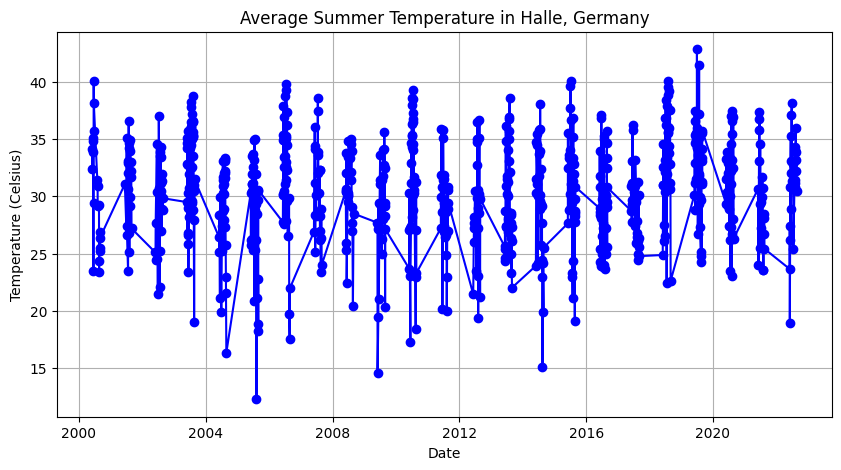

In [16]:
halle = ee.Geometry.Point([11.97, 51.49])

# Load the MODIS Land Surface Temperature dataset
dataset = ee.ImageCollection('MODIS/006/MOD11A1') \
            .filterBounds(halle) \
            .filter(ee.Filter.calendarRange(6, 8, 'month'))  # Filter for summer months (June, July, August)

# Select the daytime land surface temperature band (LST_Day_1km)
temperature = dataset.select('LST_Day_1km')

# Convert temperature from Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15).copyProperties(image, ['system:time_start'])

temperature_celsius = temperature.map(kelvin_to_celsius)

# Calculate the average temperature for each image
def get_mean_temperature(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=halle,
        scale=1000,
        maxPixels=1e9
    )
    mean_temp = mean_dict.get('LST_Day_1km')
    return ee.Feature(None, {'mean_temp': mean_temp, 'date': image.date().format()})

mean_temp_features = temperature_celsius.map(get_mean_temperature).filter(ee.Filter.notNull(['mean_temp']))

# Convert to a list of dictionaries
mean_temp_list = mean_temp_features.getInfo()['features']

# Extract dates and temperatures
dates = [pd.to_datetime(feature['properties']['date']) for feature in mean_temp_list]
temps = [feature['properties']['mean_temp'] for feature in mean_temp_list]

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Temperature (C)': temps})

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Temperature (C)'], marker='o', linestyle='-', color='b')
plt.title('Average Summer Temperature in Halle, Germany')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

### Task:

Discuss potential data quality issues and solutions. Do the results (temperatures) change if you employ a BAP composition? Add another line to the time series plot, displaying temperatures extracted from the BAP composites.

Discussion on Data Quality Issues and Solutions
1. Potential Data Quality Issues

    Cloud Contamination:
        Description: Clouds can obscure the surface, leading to inaccurate temperature readings.
        Solution: Use datasets with cloud cover filters and employ cloud masking techniques.

    Temporal and Spatial Resolution:
        Description: Different datasets have varying temporal and spatial resolutions, which may affect the analysis.
        Solution: Choose datasets with consistent resolution suitable for the study area and temporal span.

    Sensor Calibration:
        Description: Calibration differences between sensors can result in inconsistent temperature data.
        Solution: Use harmonized datasets and apply corrections for sensor biases.

    Data Gaps:
        Description: Missing data due to cloud cover or sensor anomalies can create gaps in the time series.
        Solution: Implement data interpolation methods or use gap-filling algorithms.

    Geometric Misregistration:
        Description: Misalignment between images can cause errors in temperature extraction.
        Solution: Use precise georeferencing techniques to align images correctly.

2. Impact of BAP Composition on Temperature Results

BAP (Best Available Pixel) Composition is a technique that selects the best pixel based on criteria such as minimal cloud cover or highest quality observation over a period. This can improve data quality by:

- Reducing cloud contamination.
- Providing more consistent data by selecting the best observations.

To analyze the impact, we compare temperatures from standard processing with those from BAP composition.

In [18]:
# Task 3 here